In [295]:
import sys
sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

import sys
sys.path.insert(0, '/home/563/esh563/TINT')

# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import classification as cl
import caine_func as caf
import analysis
import boring_stats as bs

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport classification
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF
%aimport boring_stats

%pdb

base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned ON


In [2]:
path = save_dir + 'radar_63/63_2020_10.pkl'
with open(path, 'rb') as f:
    tracks_obj = pickle.load(f)

In [21]:
tracks_dir = [
    'base', 'lower_conv_level', 'higher_conv_level', 'two_levels',
    'four_levels', 'no_steiner', 'lower_ref_thresh', 'combined']

years = sorted(list(set(range(1998, 2016)) - {2007, 2008, 2000}))

for d in tracks_dir:
    for year in years:
        path = save_dir + '{}/{}1001_{}0501.pkl'.format(
            d, year, year+1)
        with open(path, 'rb') as f:
            tracks_obj = pickle.load(f)
            
        print('Fixing')
        tracks_obj = cl.redo_exclusions(tracks_obj)
        
        with open(path, 'wb') as f:
            pickle.dump(tracks_obj, f)

Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calcula

In [22]:
conv_area_radar = []
strat_area_radar = []
times_radar = []

for radar in [63, 42, 77]:
    for year in [2020, 2021]:
        print('Radar {}, year {}.'.format(radar, year))
        years_months = [
            [year, 10], [year, 11], [year, 12],
            [year+1, 1], [year+1, 2], [year+1, 3],
            [year+1, 4]]
        for year_month in years_months:
            path = save_dir + 'radar_{}/{}_{}_{:02}.pkl'.format(
                radar, radar, year_month[0], year_month[1])
            with open(path, 'rb') as f:
                tracks_obj = pickle.load(f)

            tracks_obj = tint.objects.get_exclusion_categories(tracks_obj)
            print('Fixing.')
            with open(path, 'wb') as f:
                pickle.dump(tracks_obj, f)
                
                
conv_area_ACCESS = []
strat_area_ACCESS = []
times_ACCESS = []

Radar 63, year 2020.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 63, year 2021.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 42, year 2020.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 42, year 2021.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 77, year 2020.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 77, year 2021.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.


In [23]:
for radar in [63, 42, 77]:
    for year in [2020, 2021]:
        print('Radar {}, year {}.'.format(radar, year))
        path = save_dir + 'ACCESS_{}/{}1001_{}0501.pkl'.format(
            radar, year, year+1)
        with open(path, 'rb') as f:
            tracks_obj = pickle.load(f)

        tracks_obj = tint.objects.get_exclusion_categories(tracks_obj)
        print('Fixing.')
        with open(path, 'wb') as f:
            pickle.dump(tracks_obj, f)

Radar 63, year 2020.
Fixing.
Radar 63, year 2021.
Fixing.
Radar 42, year 2020.
Fixing.
Radar 42, year 2021.
Fixing.
Radar 77, year 2020.
Fixing.
Radar 77, year 2021.
Fixing.


# Generate Figures

In [274]:
all_obs_radar = get_boring_radar_stats(['simple_duration_cond'], None)
QC_obs_radar = get_boring_radar_stats(None, None)

all_obs_weak_radar = get_boring_radar_stats(['simple_duration_cond'], 1)
QC_obs_weak_radar = get_boring_radar_stats(None, 1)

all_obs_active_radar = get_boring_radar_stats(['simple_duration_cond'], 2)
QC_obs_active_radar = get_boring_radar_stats(None, 2)

Radar 63, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calc

No included observations.
Calculating system tracks.
No included observations.
Radar 77, year 2020.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Radar 77, year 2021.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.


In [275]:
all_obs_ACCESS = get_boring_ACCESS_stats(['simple_duration_cond'], None)
QC_obs_ACCESS = get_boring_ACCESS_stats(None, None)

all_obs_weak_ACCESS = get_boring_ACCESS_stats(['simple_duration_cond'], 1)

QC_obs_weak_ACCESS = get_boring_ACCESS_stats(None, 1)

all_obs_active_ACCESS = get_boring_ACCESS_stats(['simple_duration_cond'], 2)
QC_obs_active_ACCESS = get_boring_ACCESS_stats(None, 2)

Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system 

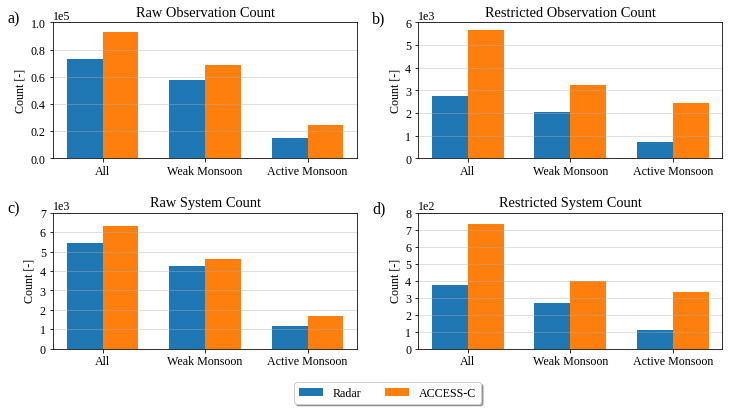

In [365]:
bs.plot_counts(
    all_obs_radar, all_obs_weak_radar, all_obs_active_radar,
    all_obs_ACCESS, all_obs_weak_ACCESS, all_obs_active_ACCESS,
    QC_obs_radar, QC_obs_weak_radar, QC_obs_active_radar,
    QC_obs_ACCESS, QC_obs_weak_ACCESS, QC_obs_active_ACCESS)

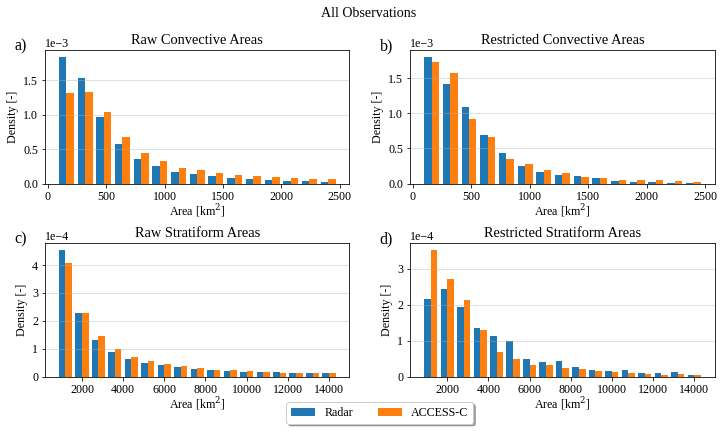

In [366]:
bs.compare_sizes(
    all_obs_radar, all_obs_ACCESS, 
    QC_obs_radar, QC_obs_ACCESS, density=True, title='All Observations')

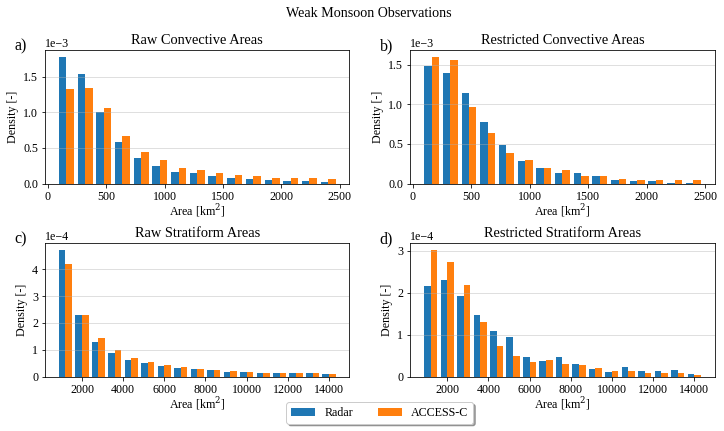

In [367]:
bs.compare_sizes(
    all_obs_weak_radar, all_obs_weak_ACCESS, 
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=True,
    title='Weak Monsoon Observations')

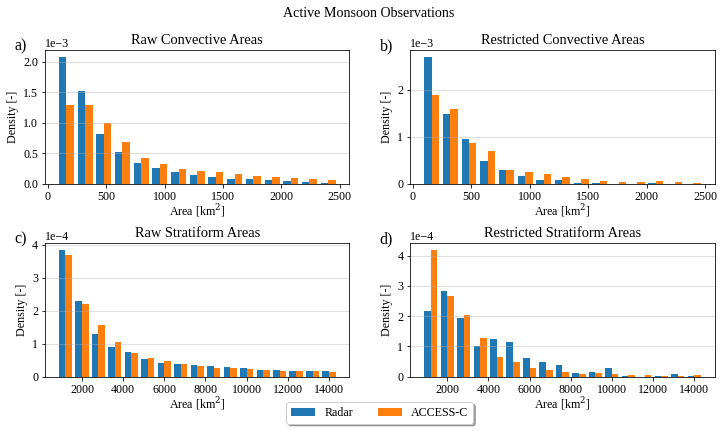

In [368]:
bs.compare_sizes(
    all_obs_active_radar, all_obs_active_ACCESS, 
    QC_obs_active_radar, QC_obs_active_ACCESS, density=True,
    title='Active Monsoon Observations')

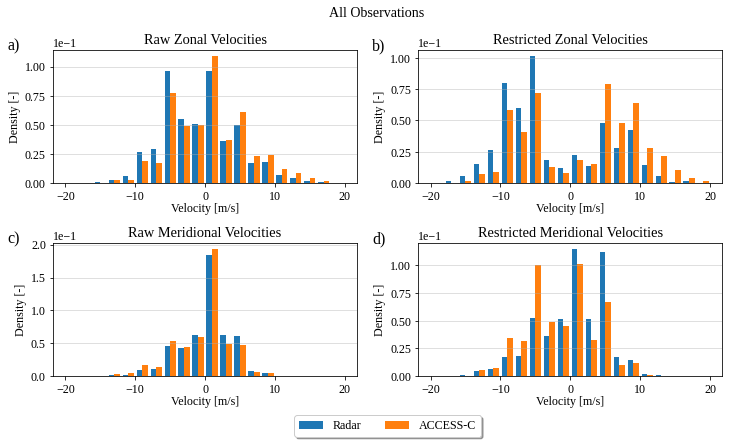

In [400]:
bs.compare_velocities(
    all_obs_radar, all_obs_ACCESS,
    QC_obs_radar, QC_obs_ACCESS, density=True, title='All Observations')

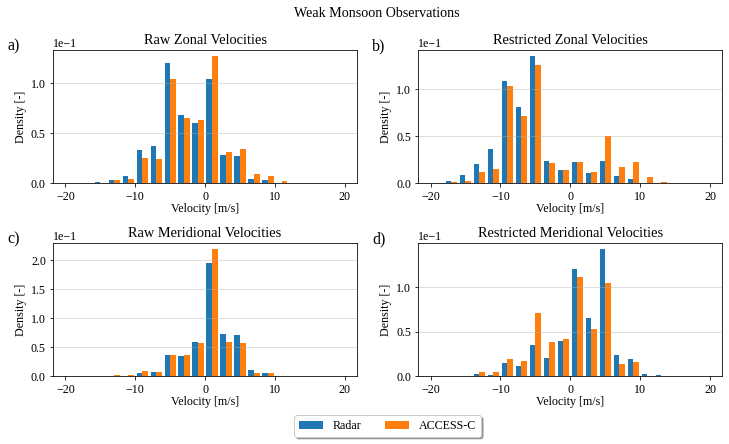

In [401]:
bs.compare_velocities(
    all_obs_weak_radar, all_obs_weak_ACCESS,
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=True, title='Weak Monsoon Observations')

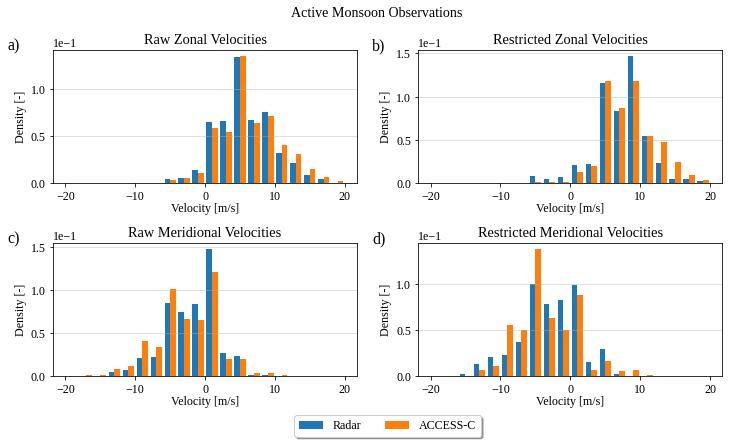

In [402]:
bs.compare_velocities(
    all_obs_active_radar, all_obs_active_ACCESS,
    QC_obs_active_radar, QC_obs_active_ACCESS, density=True, title='Active Monsoon Observations')

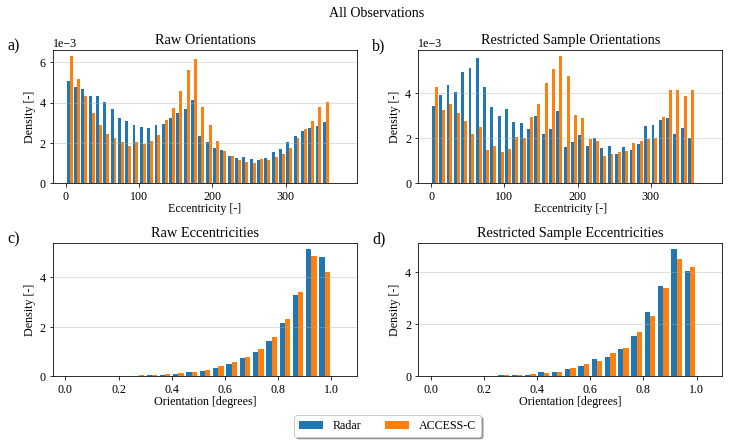

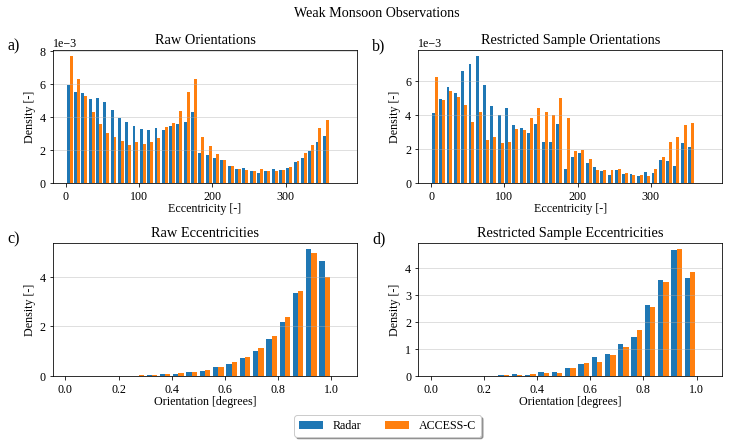

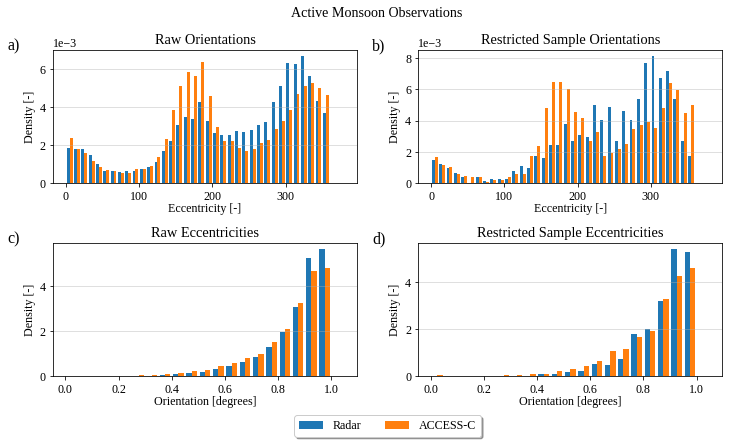

In [406]:
bs.compare_shape(
    all_obs_radar, all_obs_ACCESS,
    QC_obs_radar, QC_obs_ACCESS, density=True, 
    title='All Observations')

bs.compare_shape(
    all_obs_weak_radar, all_obs_weak_ACCESS,
    QC_obs_weak_radar, QC_obs_weak_ACCESS, density=True, 
    title='Weak Monsoon Observations')

bs.compare_shape(
    all_obs_active_radar, all_obs_active_ACCESS,
    QC_obs_active_radar, QC_obs_active_ACCESS, density=True, 
    title='Active Monsoon Observations')